# Boxplot code  
(c) 2023-2024 Nick Falk  

These codes were contributed by Nick  

This code was automatically converted from R to python by chatGPT. Use at your own risk! 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [12]:
# Step 1: Data Wrangling
# Load the taxa table
genus_otu = pd.read_csv("../MinION/Taxonomy/genus_revised_minion_202304.csv", index_col=0)
genus_otu.head()

,1068841_20180306_S,1447437_20171212_S,1128691_20171218_S,1128691_20180116_S,1590009_20171212_S,1282052_20180206_S,1316935_20180417_S,1651490_20171215_S,1447437_20171006_S,1470026_20180502_S,...,788707_20180301_S,788707_20180313_S,788707_20181116_S,802971_20180605_S,825012_20181120_S,825012_20181126_S,875028_20180115_S,892355_20180123_S,895293_20180502_S,983493_20180123_S
#NAME,,,,,,,,,,,,,,,,,,,,,
g__Parasutterella,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g__Yersinia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
g__Proteiniclasticum,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
g__Trebouxia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
g__Citricoccus,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [17]:
# Normalization/Transformation
# Square root transform
sqrt_genus = np.sqrt(genus_otu)

# Transpose the taxa table
genus_otu2 = sqrt_genus.T
genus_otu2.head()

#NAME,g__Parasutterella,g__Yersinia,g__Proteiniclasticum,g__Trebouxia,g__Citricoccus,g__Lachnobacterium,g__Enorma,g__Massilicoli,g__Lodderomyces,g__Nostoc,...,g__Acetivibrio,g__Thermofilum,g__Bodo,g__Smithella,g__Tepiditoga,g__Candidatus Sulfopaludibacter,g__Oxytricha,g__Parvicella,g__Desulforamulus,g__Amorphochlora
1068841_20180306_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1447437_20171212_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128691_20171218_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128691_20180116_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1590009_20171212_S,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Load metadata table
metadata = pd.read_csv("../MinION/Metadata/FINAL_METADATA_MINION.csv", encoding='windows-1252', index_col=0)
metadata.head()

,#NAME,minion_ID,MGI_ID_from_fastq.gz,Patient,Sample date,IP vs OP,Hospital,Room,Age,Age groups,...,Sample type,DNA_extraction_ conc,#NAME.1,ULN,Sample name,Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total_Clusters_Passing_Filter_(Million)
#NAME_From sequences,,,,,,,,,,,,,,,,,,,,,
623361_20180123_S,623361_20180123_S,623361_20180123_S,623361_20180123_S,623361,23/01/2018,OP,RAH,Chest Clinic 9,18,4,...,Sputum,0.778,623361_20180123_S,SAGCFN_22_01764,623361_20180123_S,33.60,GAGATTCC,GGCTCTGA,468,2.4
639354_20171206_S,639354_20171206_S,639354_20171206_S,639354_20171206_S,639354,6/12/2017,IP,WCH,Adolescent 10,17,3,...,Sputum,3.540,639354_20171206_S,SAGCFN_22_01742,639354_20171206_S,20.80,ATTACTCG,TAATCTTA,337,4.9
642660_20180601_S,642660_20180601_S,642660_20180601_S,642660_20180601_S,642660,1/06/2018,IP,WCH,Adol Rm 11,17,3,...,Sputum,0.538,642660_20180601_S,SAGCFN_22_01780,642660_20180601_S,21.80,GAATTCGT,GGCTCTGA,491,4.8
650003_20180207_S,650003_20180207_S,650003_20180207_S,650003_20180207_S,650003,7/02/2018,IP,WCH,Adol Room 1,17,3,...,Sputum,0.552,650003_20180207_S,SAGCFN_22_01778,650003_20180207_S,8.28,GAATTCGT,ATAGAGGC,476,5.7
658355_20171204_S,658355_20171204_S,658355_20171204_S,658355_20171204_S,658355,4/12/2017,OP,WCH,Gilbert S Meeting,16,3,...,Sputum,0.433,658355_20171204_S,SAGCFN_22_01789,658355_20171204_S,16.60,CTGAAGCT,AGGCGAAG,507,4.5


In [20]:
# Add "X" character to the beginning of each row name in the metadata table
# We skip this, because it is an R thing, I don't think you can have indexes that start with integers in R?
# metadata.index = 'X' + metadata.index.astype(str)

In [21]:
# Merge the taxa table and metadata table by the shared row names
merged1 = pd.merge(metadata, genus_otu2, left_index=True, right_index=True)
merged1.head()

,#NAME,minion_ID,MGI_ID_from_fastq.gz,Patient,Sample date,IP vs OP,Hospital,Room,Age,Age groups,...,g__Acetivibrio,g__Thermofilum,g__Bodo,g__Smithella,g__Tepiditoga,g__Candidatus Sulfopaludibacter,g__Oxytricha,g__Parvicella,g__Desulforamulus,g__Amorphochlora
623361_20180123_S,623361_20180123_S,623361_20180123_S,623361_20180123_S,623361,23/01/2018,OP,RAH,Chest Clinic 9,18,4,...,1.414214,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639354_20171206_S,639354_20171206_S,639354_20171206_S,639354_20171206_S,639354,6/12/2017,IP,WCH,Adolescent 10,17,3,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642660_20180601_S,642660_20180601_S,642660_20180601_S,642660_20180601_S,642660,1/06/2018,IP,WCH,Adol Rm 11,17,3,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
650003_20180207_S,650003_20180207_S,650003_20180207_S,650003_20180207_S,650003,7/02/2018,IP,WCH,Adol Room 1,17,3,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658355_20171204_S,658355_20171204_S,658355_20171204_S,658355_20171204_S,658355,4/12/2017,OP,WCH,Gilbert S Meeting,16,3,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
merged1['CMS_Pseudomonas aeruginosa']

623361_20180123_S     1.0
639354_20171206_S     1.0
642660_20180601_S     0.0
650003_20180207_S     1.0
658355_20171204_S     0.0
658355_20180122_S     0.0
658355_20180321_S     1.0
673895_20180122_S     0.0
673895_20180205_S     0.0
676138_20180130_S     0.0
698917_20171207_S     0.0
698917_20180119_S     0.0
698917_20180128_S     0.0
715927_20180205_S     0.0
748160_20180321_S     1.0
748160_20180329_S     0.0
748699_20180329_S     0.0
748699_20180410_S     0.0
752797_20170927_S     0.0
753522_20180606_S     0.0
756934_20181218_S     0.0
763742_20180129_S     0.0
768745_20171123_S     0.0
770590_20180115_S     0.0
778851_20171204_S     0.0
785991_20171129_S     0.0
785991_20171206_S     0.0
785991_20180321_S     0.0
788707_20171213_S     0.0
788707_20180301_S     0.0
788707_20180313_S     NaN
788707_20181116_S     0.0
802971_20180605_S     1.0
825012_20181120_S     0.0
825012_20181126_S     0.0
875028_20180115_S     0.0
892355_20180123_S     0.0
895293_20180502_S     1.0
983493_20180

In [26]:
# Convert the columns of interest to categorical type (similar to R factors)
# Note, python allows spaces in column names!
culture_columns = [
    'CMS_Pseudomonas aeruginosa',
    'CMS_Stenophotomonas maltophilia',
    'NTM',
    'CMS_Mycobacteroides abscessus',
    'CMS_Mycobacterium intracellulare',
    'CMS_Staphylococcus  aureus',
    'CMS_Achromobacter xylosoxidans',
    'CMS_Burkholderia cepacia',
    'CMS_Haemophilus influenzae'
]

for col in culture_columns:
    merged1[col] = merged1[col].astype('category')


In [31]:
# Step 2: Create Boxplots
def create_boxplot(data, culture_taxa, taxa):
    subset_data = data[data[culture_taxa].notna()]
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=culture_taxa, y=taxa, data=subset_data, color='black', boxprops=dict(facecolor='white'))
    sns.stripplot(x=culture_taxa, y=taxa, data=subset_data, color='black', jitter=True, alpha=0.5)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("Abundance in Patient")
    plt.xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

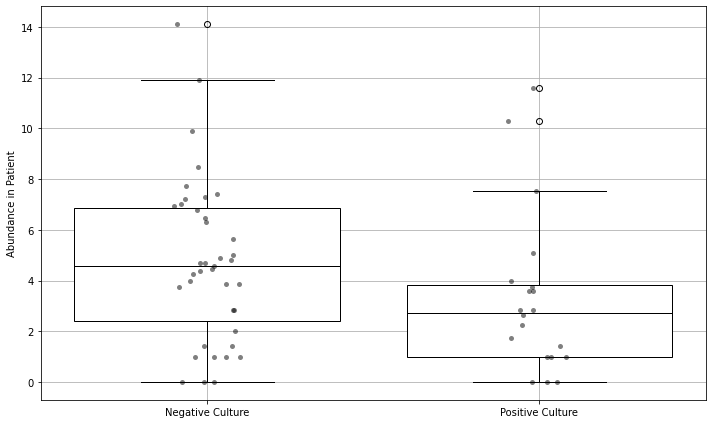

In [32]:
# Example usage
create_boxplot(merged1, "CMS_Pseudomonas aeruginosa", "g__Pseudomonas")

In [34]:
# Step 3: Additionally Stats Tests
# Perform Kruskal-Wallis Test
kruskal_stat, p_value = stats.kruskal(
    merged1.loc[merged1['CMS_Pseudomonas aeruginosa'] == 0.0, 'g__Pseudomonas'],
    merged1.loc[merged1['CMS_Pseudomonas aeruginosa'] == 1.0, 'g__Pseudomonas']
)
print(f'Kruskal-Wallis Test statistic: {kruskal_stat}, p-value: {p_value}')

Kruskal-Wallis Test statistic: 4.116373084064359, p-value: 0.04247003653928563


In [38]:
# Calculate median
g__CMS_Pseudomonas_aeruginosa_median = merged1.groupby('CMS_Pseudomonas aeruginosa', observed=True)['g__Pseudomonas'].median()
print(g__CMS_Pseudomonas_aeruginosa_median)

CMS_Pseudomonas aeruginosa
0.0    4.582576
1.0    2.737089
Name: g__Pseudomonas, dtype: float64


In [40]:
# Filter to get the threshold value for hits in the "0" grouping
threshold_CMS_Pseudomonas_aeruginosa = g__CMS_Pseudomonas_aeruginosa_median.loc[1]
print(threshold_CMS_Pseudomonas_aeruginosa)

2.7370892179053907


In [42]:
# Find row names where the value is above the threshold
above_threshold_rownames_CMS_Pseudomonas_aeruginosa = merged1[
    (merged1['CMS_Pseudomonas aeruginosa'] == 0) &
    (merged1['g__Pseudomonas'] > threshold_CMS_Pseudomonas_aeruginosa)
].index.tolist()
# Print the row names
print(above_threshold_rownames_CMS_Pseudomonas_aeruginosa)

['642660_20180601_S', '658355_20171204_S', '658355_20180122_S', '676138_20180130_S', '698917_20180128_S', '715927_20180205_S', '748699_20180329_S', '748699_20180410_S', '753522_20180606_S', '756934_20181218_S', '763742_20180129_S', '768745_20171123_S', '770590_20180115_S', '778851_20171204_S', '785991_20171129_S', '785991_20171206_S', '785991_20180321_S', '788707_20181116_S', '825012_20181120_S', '825012_20181126_S', '875028_20180115_S', '892355_20180123_S', '1586713_20180309_S', '1590009_20171212_S', '1651490_20171010_S', '1651490_20180206_S', '1651490_20171215_S', '1834617_20180501_S', '1845116_20180403_S']


In [43]:
# Save results to CSV
pd.DataFrame(above_threshold_rownames_CMS_Pseudomonas_aeruginosa).to_csv("CMS_Pseudomonas.aeruginosa.csv", index=False)

In [44]:
# Run pairwise Wilcoxon test on groups within a column


results = stats.wilcoxon(
    merged1['g__Pseudomonas'][merged1['CMS_Pseudomonas aeruginosa'] == 0],
    merged1['g__Pseudomonas'][merged1['CMS_Pseudomonas aeruginosa'] == 1]
)

p_adj = multipletests([results.pvalue], method='fdr_bh')[1][0]
print(f'Adjusted p-value for pairwise test: {p_adj}')


ValueError: The samples x and y must have the same length.